**Import Libraries**

In [1]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.sql.functions import col,split,expr,regexp_extract,sum as _sum,round as _round,date_format,datediff,unix_timestamp, avg as _avg, day, month, hour, when
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import bar_chart_race as bcr

**Create PySpark session**

In [2]:
spark=SparkSession.builder \
    .appName('airports_data_analysis') \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.jars", "postgresql-42.5.1.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.5.1.jar") \
    .getOrCreate()    

In [4]:
spark_df_aircrafts_data = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.aircrafts_data",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

spark_df_airports_data = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.airports_data",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

spark_df_boarding_passes = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.boarding_passes",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

spark_df_bookings = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.bookings",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

spark_df_flights = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.flights",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

spark_df_seats = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.seats",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

spark_df_ticket_flights = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.ticket_flights",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

spark_df_tickets = spark.read \
    .jdbc("jdbc:postgresql://host.docker.internal:8001/demo", "bookings.tickets",
          properties={"user": "postgres", "password": "postgres", "driver": "org.postgresql.Driver"})

**Aircrafts Table**

In [4]:
spark_df_aircrafts_data.show()

+-------------+--------------------+-----+
|aircraft_code|               model|range|
+-------------+--------------------+-----+
|          773|{"en": "Boeing 77...|11100|
|          763|{"en": "Boeing 76...| 7900|
|          SU9|{"en": "Sukhoi Su...| 3000|
|          320|{"en": "Airbus A3...| 5700|
|          321|{"en": "Airbus A3...| 5600|
|          319|{"en": "Airbus A3...| 6700|
|          733|{"en": "Boeing 73...| 4200|
|          CN1|{"en": "Cessna 20...| 1200|
|          CR2|{"en": "Bombardie...| 2700|
+-------------+--------------------+-----+



**Statistics of Planes Range**

In [5]:
statistics = spark_df_aircrafts_data.describe("range")
statistics_rounded = statistics.withColumn("range", func.round(statistics["range"], 2))
statistics_rounded.show()

+-------+-------+
|summary|  range|
+-------+-------+
|  count|    9.0|
|   mean|5344.44|
| stddev|3013.76|
|    min| 1200.0|
|    max|11100.0|
+-------+-------+



**Count of Planes per Airplane Manufacturer**

In [6]:
spark_df_aircrafts_data = spark_df_aircrafts_data.withColumn("model_map", expr("from_json(model, 'MAP<STRING, STRING>')"))

spark_df_aircrafts_data = spark_df_aircrafts_data.withColumn('model_str', expr("concat_ws(' | ', map_values(model_map))"))
spark_df_aircrafts_data = spark_df_aircrafts_data.withColumn("manufacturer", split(col("model_str"), " ").getItem(0))

grouped_df = spark_df_aircrafts_data.groupBy("manufacturer").count().orderBy(col("count").desc())
grouped_df.show()


+------------+-----+
|manufacturer|count|
+------------+-----+
|      Boeing|    3|
|      Airbus|    3|
|      Sukhoi|    1|
|      Cessna|    1|
|  Bombardier|    1|
+------------+-----+



**Airports Table**

In [7]:
regex_pattern_city = r"^([A-Za-z\.\-]+(?:\s[A-Za-z\.\-]+)?)"
regex_pattern_airport = r"^([A-Za-z\u0400-\u04FF\.\-]+(?:\s[A-Za-z\u0400-\u04FF\.\-]+)*)"

spark_df_airports_data = spark_df_airports_data.withColumn("airport_name_map", expr("from_json(airport_name, 'MAP<STRING, STRING>')"))
spark_df_airports_data = spark_df_airports_data.withColumn("city_map", expr("from_json(city, 'MAP<STRING, STRING>')"))

spark_df_airports_data = spark_df_airports_data.withColumn("airport_name_final", regexp_extract(expr("concat_ws(' | ', map_values(airport_name_map))"), regex_pattern_airport, 1))
spark_df_airports_data = spark_df_airports_data.withColumn("city_name_final", regexp_extract(expr("concat_ws(' | ', map_values(city_map))"), regex_pattern_city, 1))

spark_df_airports_data = spark_df_airports_data.drop('airport_name', 'city', 'airport_name_map', 'city_map')
spark_df_airports_data = spark_df_airports_data.withColumnRenamed("airport_name_final", "airport_name").withColumnRenamed("city_name_final", "city_name")

spark_df_airports_data.show()

+------------+--------------------+------------------+--------------------+-----------------+
|airport_code|         coordinates|          timezone|        airport_name|        city_name|
+------------+--------------------+------------------+--------------------+-----------------+
|         YKS|(129.77099609375,...|      Asia/Yakutsk|     Yakutsk Airport|          Yakutsk|
|         MJZ|(114.039001464843...|      Asia/Yakutsk|       Mirny Airport|           Mirnyj|
|         KHV|(135.18800354004,...|  Asia/Vladivostok|Khabarovsk-Novy A...|       Khabarovsk|
|         PKC|(158.453994750976...|    Asia/Kamchatka|    Yelizovo Airport|    Petropavlovsk|
|         UUS|(142.718002319335...|     Asia/Sakhalin|Yuzhno-Sakhalinsk...|Yuzhno-Sakhalinsk|
|         VVO|(132.147994995117...|  Asia/Vladivostok|Vladivostok Inter...|      Vladivostok|
|         LED|(30.2625007629394...|     Europe/Moscow|     Pulkovo Airport|   St. Petersburg|
|         KGD|(20.5925998687744...|Europe/Kaliningrad|   Khr

**Boarding Passes Table**

In [8]:
spark_df_boarding_passes.show()

+-------------+---------+-----------+-------+
|    ticket_no|flight_id|boarding_no|seat_no|
+-------------+---------+-----------+-------+
|0005435189093|   198393|          1|    27G|
|0005435189119|   198393|          2|     2D|
|0005435189096|   198393|          3|    18E|
|0005435189117|   198393|          4|    31B|
|0005432208788|   198393|          5|    28C|
|0005435189151|   198393|          6|    32A|
|0005433655456|   198393|          7|    31J|
|0005435189129|   198393|          8|    30C|
|0005435629876|   198393|          9|    30E|
|0005435189100|   198393|         10|    30F|
|0005435189112|   198393|         11|    28G|
|0005435189152|   198393|         12|    30K|
|0005435189102|   198393|         13|    31A|
|0005435189146|   198393|         14|    29G|
|0005435189132|   198393|         15|    29D|
|0005435189142|   198393|         16|    20G|
|0005432208786|   198393|         17|    20C|
|0005435189104|   198393|         18|    21B|
|0005435189135|   198393|         

**Bookings Table**

In [9]:
spark_df_bookings.show()

+--------+-------------------+------------+
|book_ref|          book_date|total_amount|
+--------+-------------------+------------+
|  000004|2016-08-13 12:40:00|    55800.00|
|  00000F|2017-07-05 00:12:00|   265700.00|
|  000010|2017-01-08 16:45:00|    50900.00|
|  000012|2017-07-14 06:02:00|    37900.00|
|  000026|2016-08-30 08:08:00|    95600.00|
|  00002D|2017-05-20 15:45:00|   114700.00|
|  000034|2016-08-08 02:46:00|    49100.00|
|  00003F|2016-12-12 12:02:00|   109800.00|
|  000048|2016-09-16 22:57:00|    92400.00|
|  00004A|2016-10-13 18:57:00|    29000.00|
|  000050|2016-09-17 21:01:00|    36200.00|
|  000055|2017-03-08 19:18:00|    50800.00|
|  000061|2016-11-11 18:28:00|    35600.00|
|  000067|2016-08-11 18:36:00|   102100.00|
|  000068|2017-08-15 11:27:00|    18100.00|
|  00006A|2016-11-05 02:02:00|   106100.00|
|  00006B|2016-11-29 04:59:00|   382000.00|
|  00007A|2016-10-18 17:55:00|     8200.00|
|  00007C|2016-09-26 20:00:00|    22600.00|
|  00007D|2016-12-31 16:49:00|  

**Flights Table**

In [10]:
spark_df_flights.show()

+---------+---------+-------------------+-------------------+-----------------+---------------+---------+-------------+----------------+--------------+
|flight_id|flight_no|scheduled_departure|  scheduled_arrival|departure_airport|arrival_airport|   status|aircraft_code|actual_departure|actual_arrival|
+---------+---------+-------------------+-------------------+-----------------+---------------+---------+-------------+----------------+--------------+
|     2880|   PG0216|2017-09-14 11:10:00|2017-09-14 12:15:00|              DME|            KUF|Scheduled|          763|            NULL|          NULL|
|     3940|   PG0212|2017-09-04 15:20:00|2017-09-04 16:35:00|              DME|            ROV|Scheduled|          321|            NULL|          NULL|
|     4018|   PG0416|2017-09-13 16:20:00|2017-09-13 16:55:00|              DME|            VOZ|Scheduled|          CR2|            NULL|          NULL|
|     4587|   PG0055|2017-09-03 11:10:00|2017-09-03 12:25:00|              DME|         

**Seats Table**

In [11]:
spark_df_seats.show()

+-------------+-------+---------------+
|aircraft_code|seat_no|fare_conditions|
+-------------+-------+---------------+
|          319|     2A|       Business|
|          319|     2C|       Business|
|          319|     2D|       Business|
|          319|     2F|       Business|
|          319|     3A|       Business|
|          319|     3C|       Business|
|          319|     3D|       Business|
|          319|     3F|       Business|
|          319|     4A|       Business|
|          319|     4C|       Business|
|          319|     4D|       Business|
|          319|     4F|       Business|
|          319|     5A|       Business|
|          319|     5C|       Business|
|          319|     5D|       Business|
|          319|     5F|       Business|
|          319|     6A|        Economy|
|          319|     6B|        Economy|
|          319|     6C|        Economy|
|          319|     6D|        Economy|
+-------------+-------+---------------+
only showing top 20 rows



**Ticket Flights Table**

In [12]:
spark_df_ticket_flights.show()

+-------------+---------+---------------+---------+
|    ticket_no|flight_id|fare_conditions|   amount|
+-------------+---------+---------------+---------+
|0005432079221|    36094|       Business| 99800.00|
|0005434861552|    65405|       Business| 49700.00|
|0005432003235|    89752|       Business| 99800.00|
|0005433567794|   164215|       Business|105900.00|
|0005432003470|    89913|       Business| 99800.00|
|0005435834642|   117026|       Business|199300.00|
|0005432003656|    90106|       Business| 99800.00|
|0005432949087|   164161|       Business|105900.00|
|0005432801137|     9563|       Business|150400.00|
|0005433557112|   164098|       Business|105900.00|
|0005435472060|    38913|       Business|199300.00|
|0005435988210|   102289|       Business|145300.00|
|0005435472136|    39007|       Business|199300.00|
|0005434846823|    65312|       Business| 49700.00|
|0005435472507|    38867|       Business|199300.00|
|0005434863576|    65557|       Business| 49700.00|
|00054328014

**Tickets Table**

In [13]:
spark_df_tickets.show()

+-------------+--------+------------+--------------------+--------------------+
|    ticket_no|book_ref|passenger_id|      passenger_name|        contact_data|
+-------------+--------+------------+--------------------+--------------------+
|0005432000284|  1A40A1| 4030 855525|     MIKHAIL SEMENOV|{"phone": "+70110...|
|0005432000285|  13736D| 8360 311602|     ELENA ZAKHAROVA|{"phone": "+70670...|
|0005432000286|  DC89BC| 4510 377533|         ILYA PAVLOV|{"phone": "+70624...|
|0005432000287|  CDE08B| 5952 253588|        ELENA BELOVA|{"email": "e.belo...|
|0005432000288|  BEFB90| 4313 788533|   VYACHESLAV IVANOV|{"email": "vyache...|
|0005432000289|  A903E4| 2742 028983|  NATALIYA NESTEROVA|{"phone": "+70031...|
|0005432000290|  CC77B6| 9873 744760|ALEKSANDRA ARKHIPOVA|{"email": "arkhip...|
|0005432000291|  D530F6| 2695 977692|     EVGENIY SERGEEV|{"phone": "+70007...|
|0005432000292|  F26006| 2512 253082|     TATYANA ZHUKOVA|{"email": "zhukov...|
|0005432000293|  739B4E| 5763 638275|   

**Flights Number per Manufacturer**

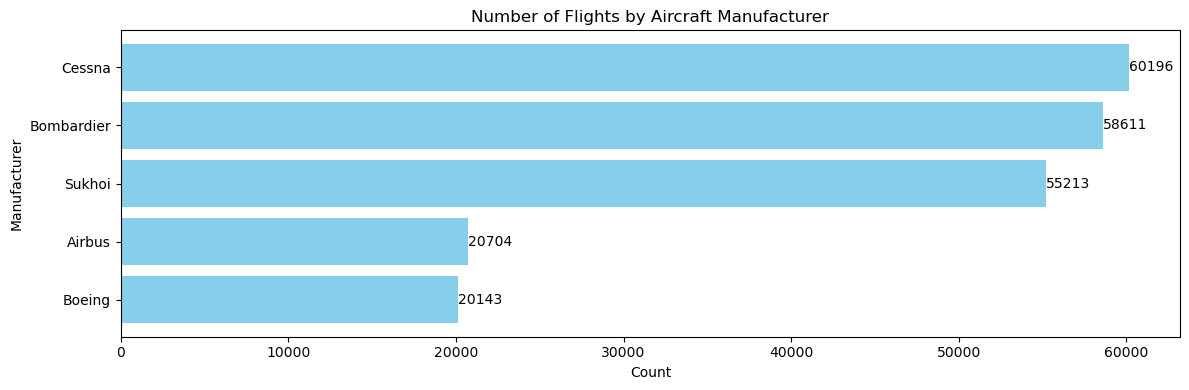

In [14]:
df = spark_df_flights.join(spark_df_aircrafts_data, spark_df_flights['aircraft_code'] == spark_df_aircrafts_data['aircraft_code'], "left")
grouped_df = df.groupBy("manufacturer").count().orderBy(col("count").desc())

grouped_pd_df = grouped_df.toPandas()

plt.figure(figsize=(12, 4))
bars = plt.barh(grouped_pd_df['manufacturer'], grouped_pd_df['count'], color='skyblue')

for bar, count in zip(bars, grouped_pd_df['count']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', va='center', ha='left', fontsize=10)

plt.xlabel('Count')
plt.ylabel('Manufacturer')
plt.title('Number of Flights by Aircraft Manufacturer')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Most Occupied Airports**

/tmp/ipykernel_94/3586868287.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='airport_name', y='Passengers', data=pandas_df[:20], palette=sns.color_palette("dark",20))


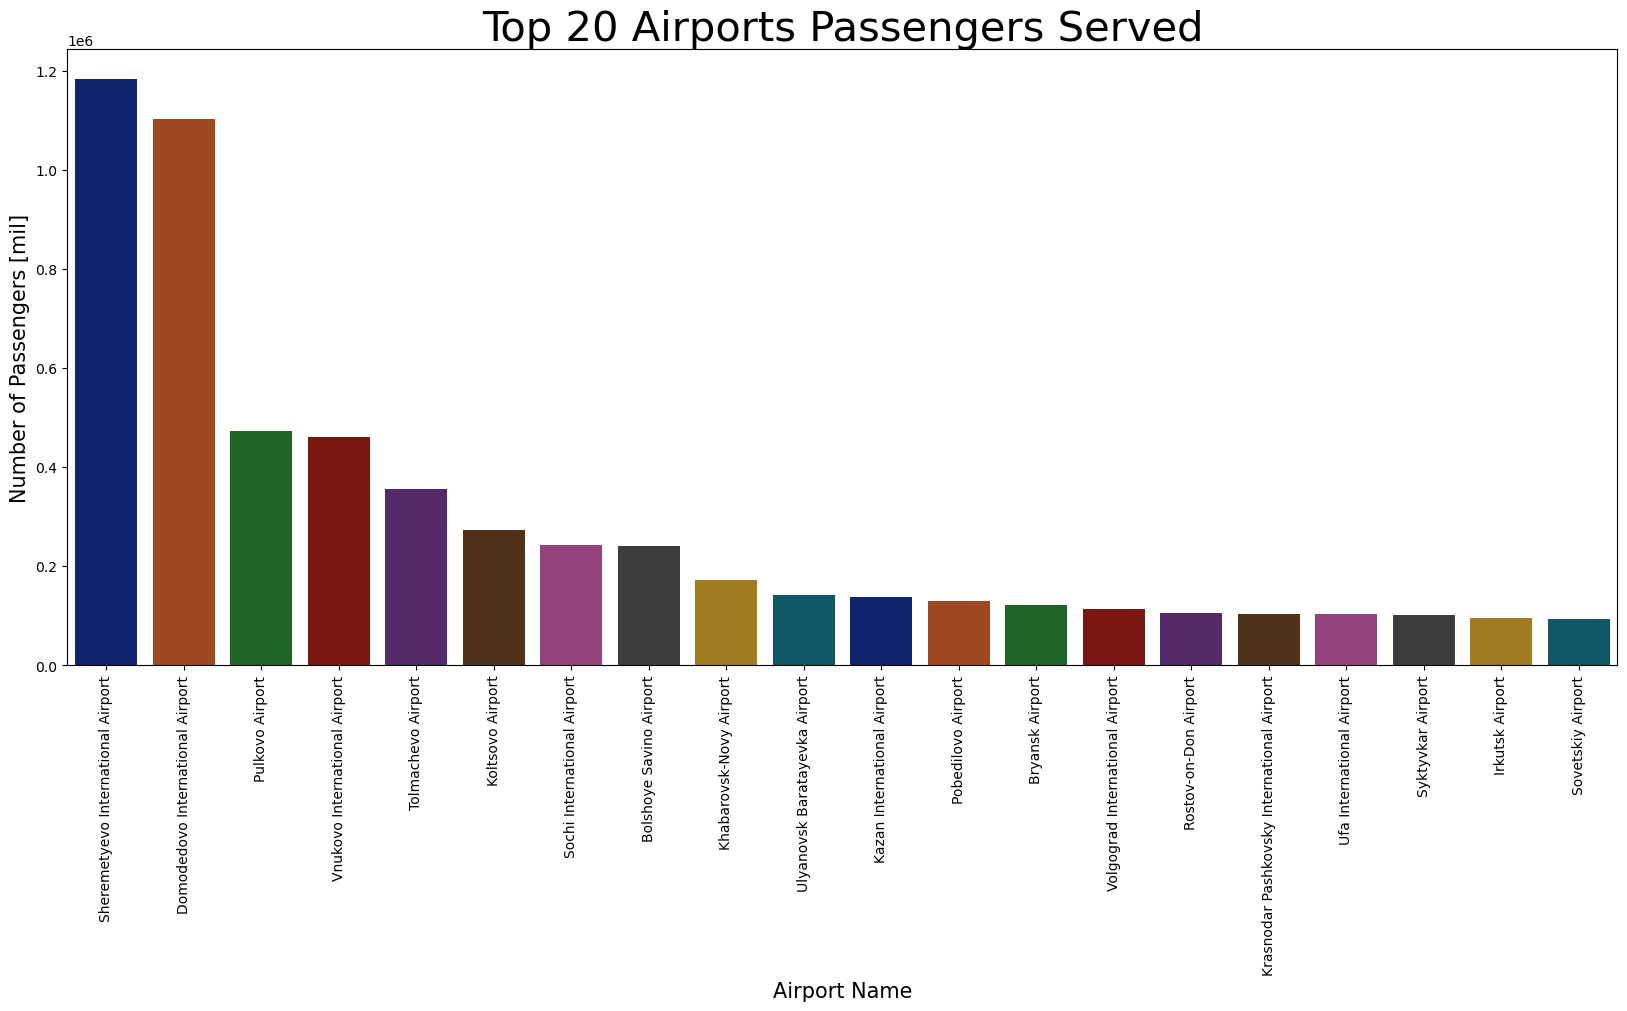

In [15]:
df_1 = spark_df_ticket_flights.groupBy("flight_id").count()

df = spark_df_flights.join(df_1, spark_df_flights['flight_id'] == df_1['flight_id'], "left")
df = df.where("status = 'Arrived'")
df = df.na.fill(value=0,subset=["count"])
df = df.join(spark_df_airports_data, df['departure_airport'] == spark_df_airports_data['airport_code'], "left")
grouped_df = df.groupBy("airport_name").agg(_sum("count").alias("Passengers")).orderBy(col("Passengers").desc())

pandas_df = grouped_df.toPandas()

plt.figure(figsize=(20, 8))
plt.title('Top 20 Airports Passengers Served', fontsize=30)
sns.barplot(x='airport_name', y='Passengers', data=pandas_df[:20], palette=sns.color_palette("dark",20))
plt.xticks(rotation=90)
plt.xlabel('Airport Name', fontsize=15)
plt.ylabel('Number of Passengers [mil]', fontsize=15)

plt.show()

**Top 25 Most Popular Names**

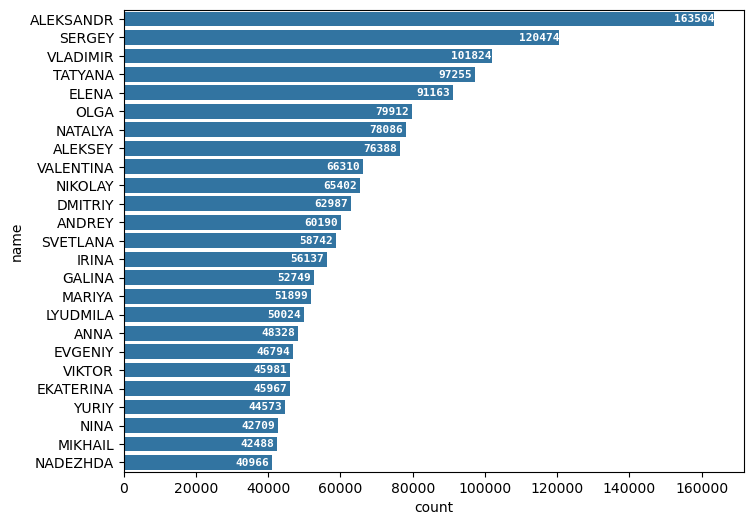

In [16]:
df = spark_df_tickets.select("passenger_id","passenger_name").distinct()
df = df.withColumn("name", split(col("passenger_name"), " ").getItem(0))

df_names = df.select("name")
grouped_df = df_names.groupBy("name").count().orderBy(col("count").desc())
top_50_names = grouped_df.limit(25)

pandas_df = top_50_names.toPandas()

plt.figure(figsize=(8, 6))

ax=sns.barplot(pandas_df, x="count", y="name")


for p in ax.patches:
    width = p.get_width()
    label = f'{width:.0f}'
    x_coord = width - 5500
    plt.text(x_coord, p.get_y() + p.get_height() / 2, label,
             ha='center', va='center', color='white',
             fontdict={'family': 'monospace', 'weight': 'bold', 'size': 8})

sns.set_style('ticks')
plt.show()

**Revenue Market Share per Fare Class**

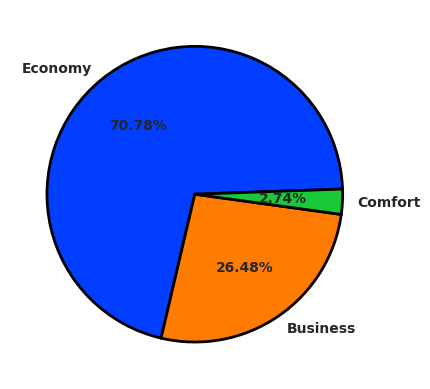

<Figure size 2.5e+07x2.5e+07 with 0 Axes>

In [17]:
df = spark_df_ticket_flights.select("fare_conditions","amount")

total_revenue = df.agg(_sum("amount").alias("total_revenue")).first()["total_revenue"]

grouped_df = df.groupBy("fare_conditions").agg(_sum("amount").alias("Revenue")).orderBy(col("fare_conditions").desc())
grouped_df = grouped_df.withColumn("Percent_of_Total", _round(col("Revenue") / total_revenue * 100, 2))
grouped_df = grouped_df.select("fare_conditions","Percent_of_Total").orderBy(col("Percent_of_Total").desc())

pandas_df = grouped_df.toPandas()

plt.pie(pandas_df['Percent_of_Total'], labels = pandas_df['fare_conditions'], colors = sns.color_palette('bright'), autopct='%1.2f%%', startangle = 2, wedgeprops = {"edgecolor" : "black", 'linewidth': 2, 'antialiased': True}, textprops={'fontsize': 10, 'fontweight': 'bold'})   
plt.figure(figsize=(250000,250000))  
plt.show() 

**Flights per Airport throught the year - Top 20 Airports Included**

In [18]:
df_chart_race = spark_df_flights

top_20_airports = spark_df_flights.where("status = 'Arrived'").groupBy("departure_airport").count().orderBy(col("count").desc()).limit(20)
top_20_airports= top_20_airports.join(spark_df_airports_data, top_20_airports['departure_airport'] == spark_df_airports_data['airport_code'], "left")
top_20_airports = top_20_airports.withColumnRenamed("airport_name", "top_airport_name")
top_20_airports = top_20_airports.select("top_airport_name")                                                                                                 

df_agg = df_chart_race.join(spark_df_airports_data, df_chart_race['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.where("status = 'Arrived'")
df_agg = df_agg.select("scheduled_departure","flight_id","airport_name")
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd"))
df_agg = df_agg.groupBy("scheduled_departure","airport_name").count().withColumnRenamed("count", "flights")

df_agg= df_agg.join(top_20_airports, df_agg['airport_name'] == top_20_airports['top_airport_name'], "inner")

bar_chart_race_df = df_agg.groupBy("scheduled_departure").pivot("airport_name").sum("flights").orderBy(col("scheduled_departure").asc())
bar_chart_race_df = bar_chart_race_df.na.fill(value=0)

bar_chart_race_df = bar_chart_race_df.toPandas()
bar_chart_race_df['scheduled_departure'] = pd.to_datetime(bar_chart_race_df['scheduled_departure'], format='%Y-%m-%d')
bar_chart_race_df.set_index('scheduled_departure', inplace=True)
bar_chart_race_df = bar_chart_race_df.cumsum()
bcr.bar_chart_race(df = bar_chart_race_df, title = 'Number of Flights')


/opt/conda/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
/opt/conda/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


**Number of Flights per Month**

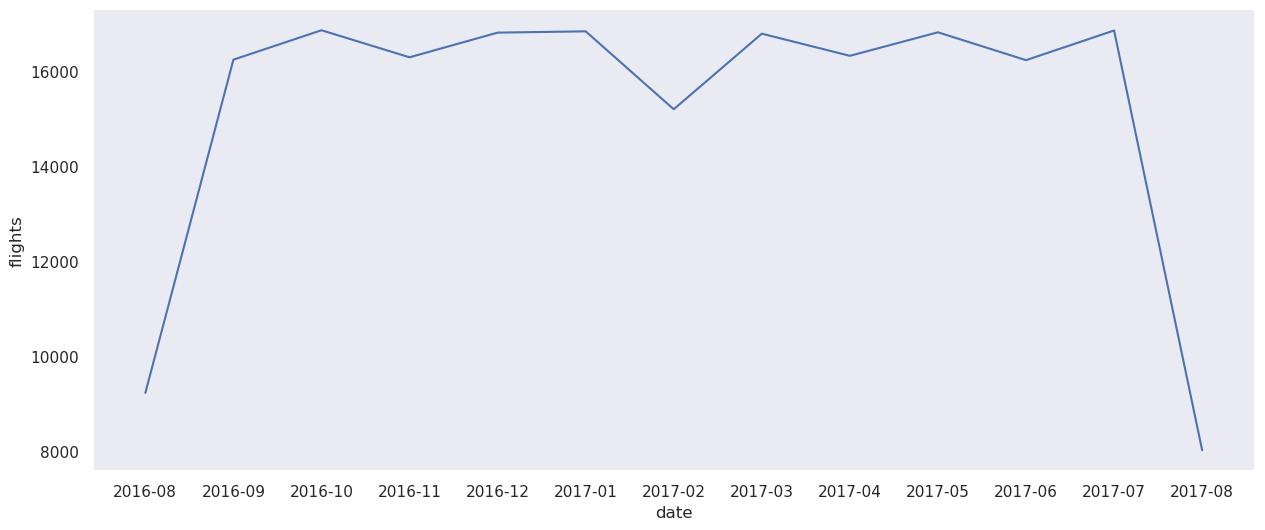

In [20]:
plt.figure(figsize=(15, 6))

df_agg = spark_df_flights
df_agg = df_agg.where("status = 'Arrived'")
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM"))
df_agg = df_agg.groupBy("scheduled_departure").count().orderBy(col("scheduled_departure").asc()).withColumnRenamed("count", "flights").withColumnRenamed("scheduled_departure", "date")

df_agg = df_agg.toPandas()
sns.lineplot(x = "date", y = "flights",data=df_agg)
sns.set(style='dark',)
plt.show()

**Top 5 Cities - Revenue - Random Order Monthly Aggregation**

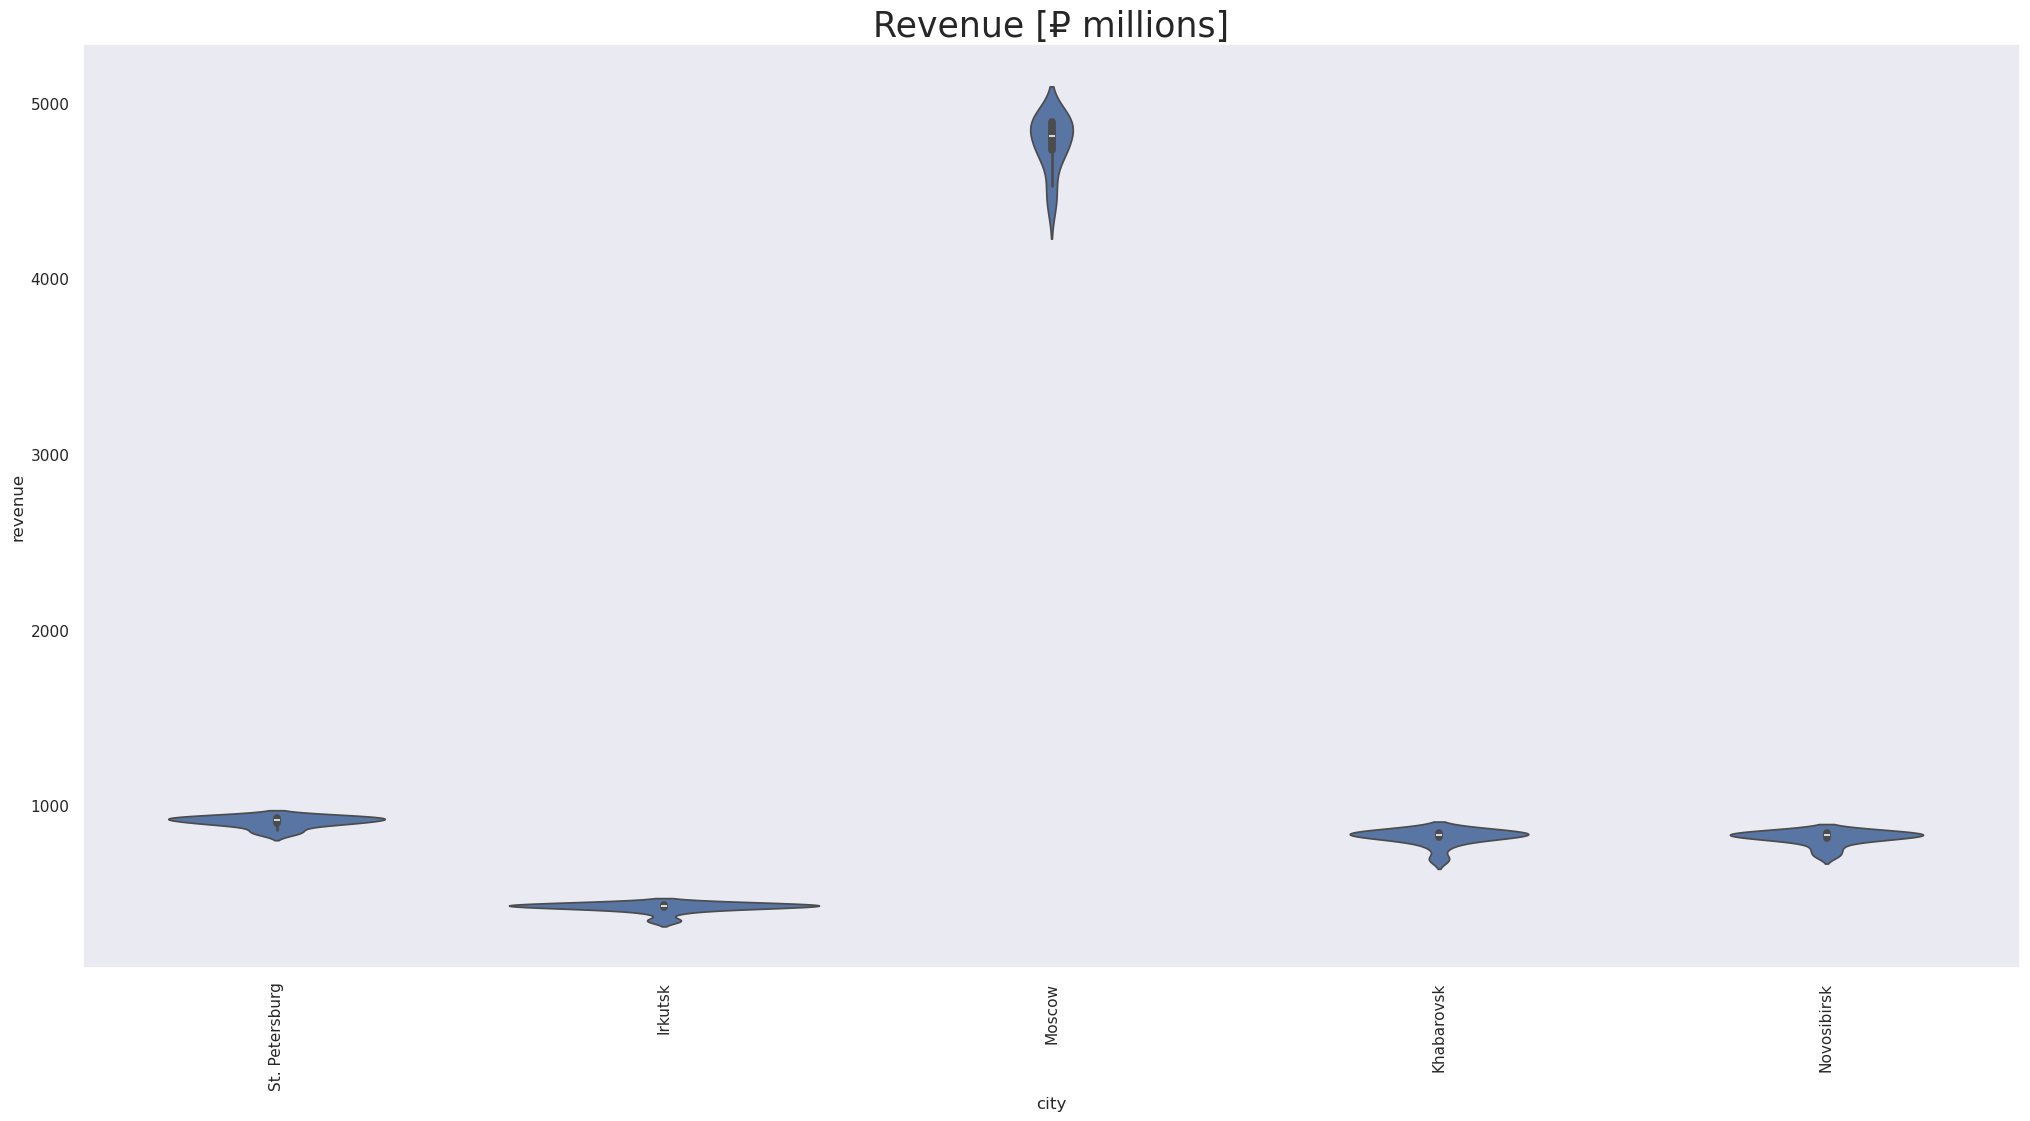

In [21]:
revenue_per_flight = spark_df_ticket_flights.groupBy('flight_id').agg(_sum("amount").alias("revenue"))

df_chart = spark_df_flights
df_chart = df_chart.na.drop(subset=["flight_id"])
df_chart = df_chart.where("status = 'Arrived'")
df_chart = df_chart.join(revenue_per_flight, df_chart['flight_id'] == revenue_per_flight['flight_id'], "left")
df_chart= df_chart.join(spark_df_airports_data, df_chart['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_chart = df_chart.na.fill(value=0,subset=["revenue"])

top_5_cities  = df_chart.groupBy("city_name").agg(_sum("revenue").alias("revenue_city")).orderBy(col("revenue_city").desc()).limit(5)

df_chart = df_chart.withColumn("month", date_format(df_chart["scheduled_departure"], "MMMM"))
df_chart = df_chart.groupBy("month", "city_name").agg(_sum("revenue").alias("revenue")).withColumnRenamed("city_name", "city")
df_chart = df_chart.join(top_5_cities, df_chart['city'] == top_5_cities['city_name'], "inner")
df_chart = df_chart.select("month","city","revenue")

df_chart = df_chart.toPandas()
df_chart['revenue'] = df_chart['revenue'] / 1_000_000

plt.figure(figsize=(25, 12))
plt.title('Revenue [₽ millions]', fontsize=25)
sns.violinplot(x="city", y="revenue", data=df_chart)
plt.xticks(rotation=90)
plt.show()

**Passengers served per month**

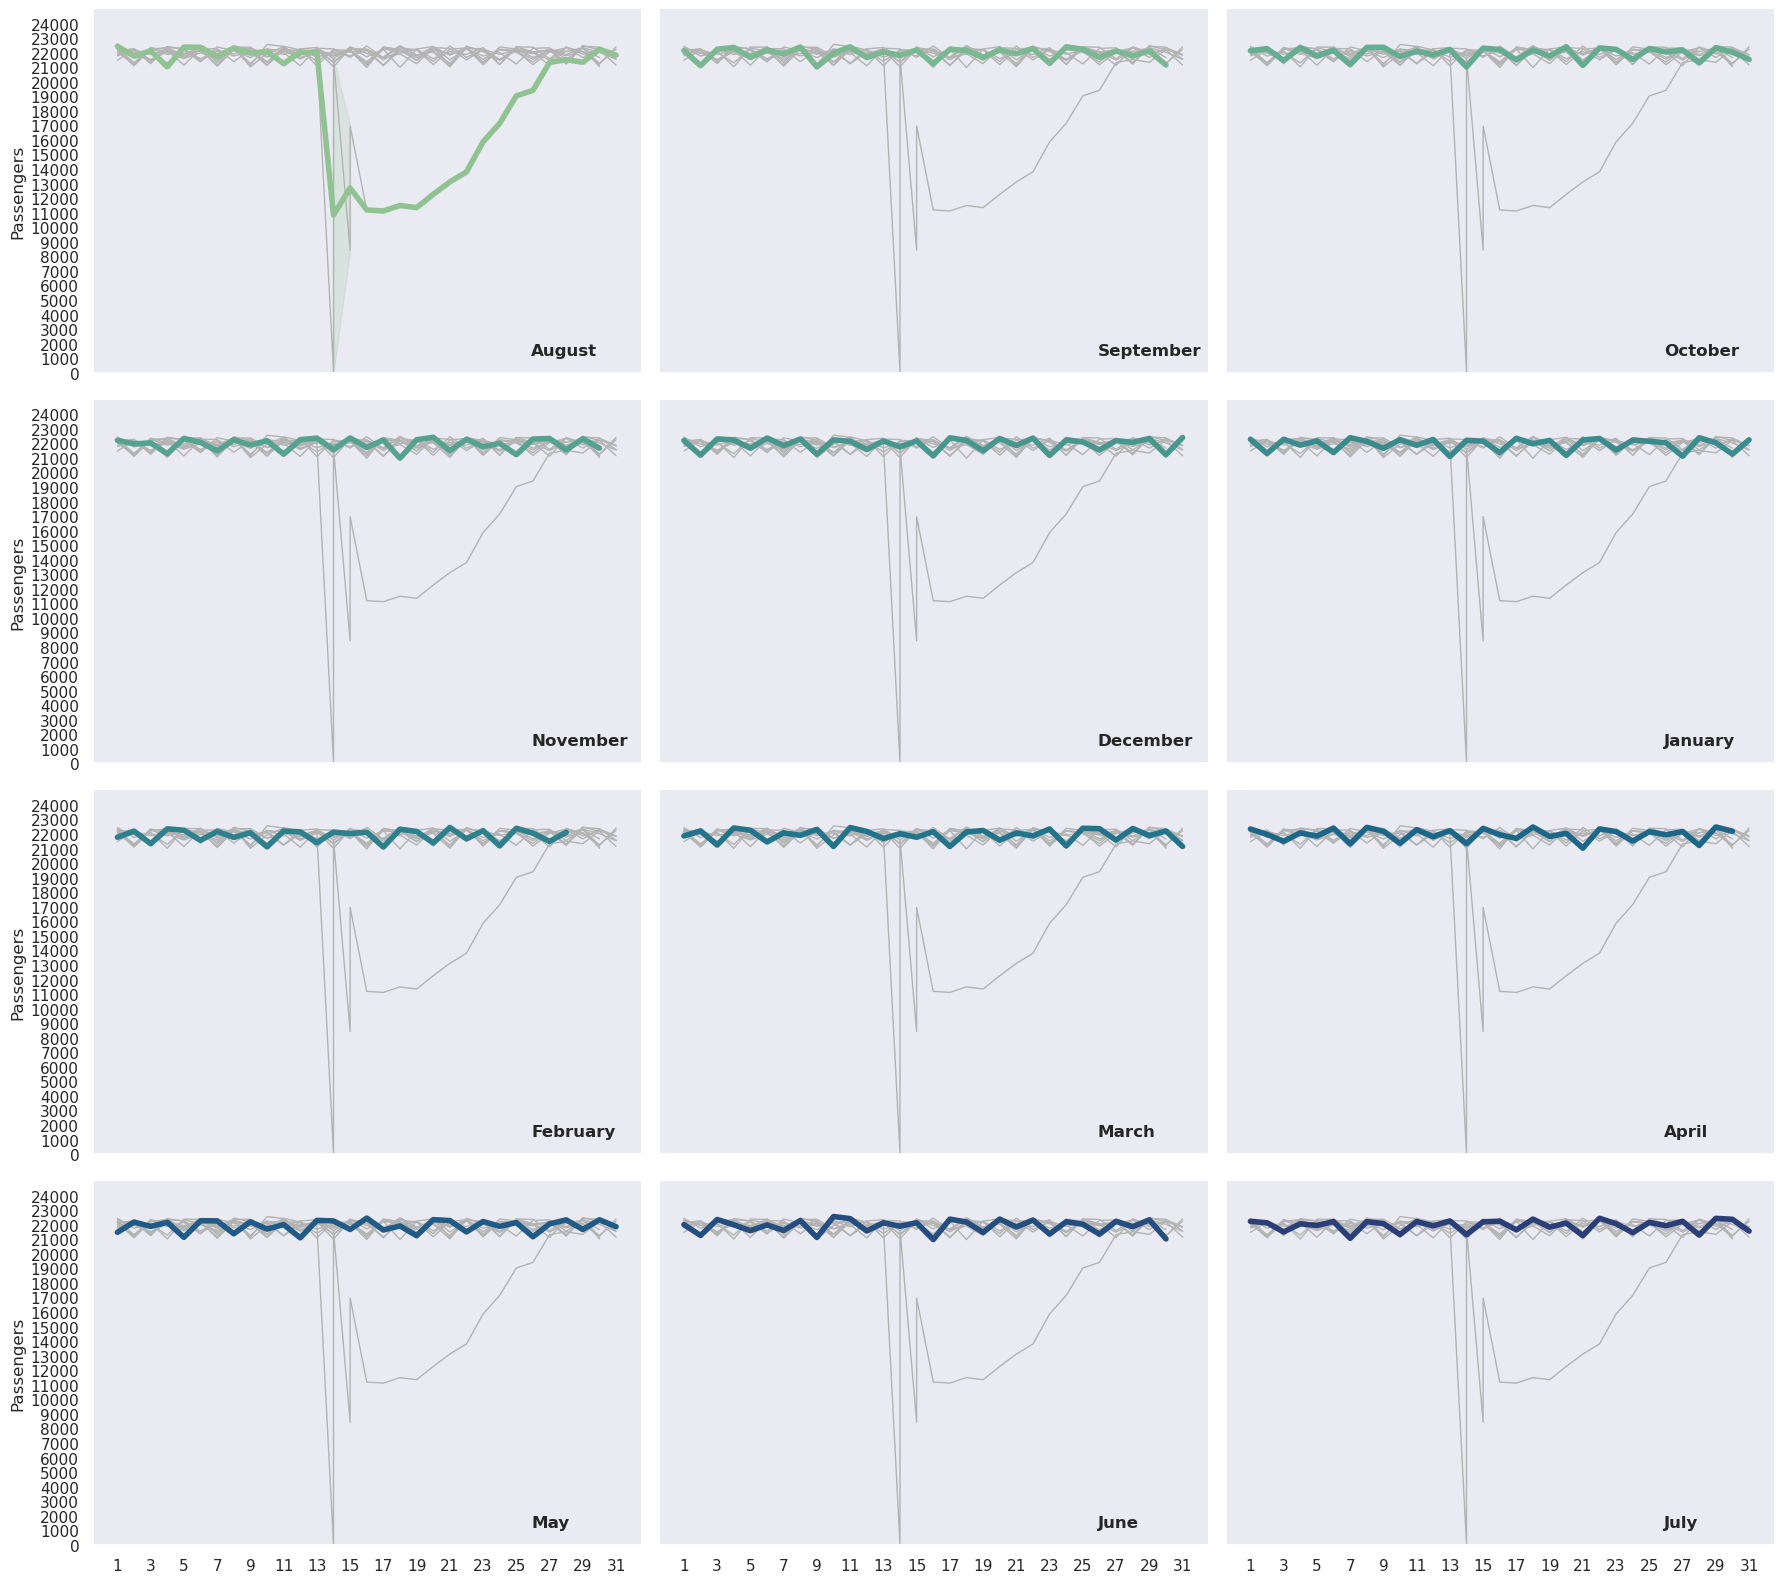

In [22]:
df_chart = spark_df_flights
tickets_per_flight = spark_df_ticket_flights.groupBy('flight_id').count()

df_chart = df_chart.join(tickets_per_flight, df_chart['flight_id'] == tickets_per_flight['flight_id'], "left")
df_chart = df_chart.where("status = 'Arrived'")
df_chart = df_chart.select("scheduled_departure","count")
df_chart = df_chart.na.fill(value=0).withColumnRenamed("count", "passengers").withColumnRenamed("scheduled_departure", "date")
df_chart = df_chart.withColumn("day", day(df_chart["date"]))
df_chart = df_chart.withColumn("month", date_format(df_chart["date"], "MMMM"))
df_chart = df_chart.withColumn("date", date_format("date", "yyyy-MM-dd"))
df_chart = df_chart.groupBy("date", "month", "day").agg(_sum("passengers").alias("passengers")).orderBy(col("date").asc())
df_chart = df_chart.select("month","day","passengers")
df_chart = df_chart.toPandas()

sns.set_theme(style="dark")

g = sns.relplot(
    data=df_chart,
    x="day", y="passengers", col="month", hue="month",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=4, aspect=1.5, legend=False,
)

for year, ax in g.axes_dict.items():    
    ax.text(.8, .05, year, transform=ax.transAxes, fontweight="bold")
    ax.set_yticks(range(0, 25000, 1000))    
    ax.set_ylim(0, 25000)
    ax.set_xticks(range(1, 32))


    sns.lineplot(
        data=df_chart, x="day", y="passengers", units="month",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

ax.set_xticks(ax.get_xticks()[::2])

g.set_titles("")
g.set_axis_labels("", "Passengers")
g.tight_layout()

### Daily Bookings per Airport

In [45]:
df_agg = spark_df_bookings
df_agg = df_agg.join(spark_df_tickets, df_agg['book_ref'] == spark_df_tickets['book_ref'], "left")
df_agg = df_agg.join(spark_df_ticket_flights, df_agg['ticket_no'] == spark_df_ticket_flights['ticket_no'], "left")
df_agg = df_agg.join(spark_df_flights, df_agg['flight_id'] == spark_df_flights['flight_id'], "left")
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")

df_agg = df_agg.select("book_date","airport_name")
df_agg = df_agg.withColumn("book_date", date_format("book_date", "yyyy-MM-dd"))
df_agg = df_agg.groupBy("book_date","airport_name").count().withColumnRenamed("count", "bookings")

df_agg.show()

+----------+--------------------+--------+
| book_date|        airport_name|bookings|
+----------+--------------------+--------+
|2017-06-01|     Pulkovo Airport|    1304|
|2016-09-16|     Pulkovo Airport|    1394|
|2016-09-21|     Pulkovo Airport|    1367|
|2016-08-20|Domodedovo Intern...|    3047|
|2016-08-01|Khabarovsk-Novy A...|     374|
|2016-12-01|      Uytash Airport|     240|
|2017-06-29|Bolshoye Savino A...|     717|
|2017-02-20|Sheremetyevo Inte...|    3274|
|2017-02-15|       Mirny Airport|     120|
|2017-01-05|      Uytash Airport|     228|
|2017-04-26|Kurumoch Internat...|     282|
|2017-04-27|Sochi Internation...|     682|
|2017-02-11|    Koltsovo Airport|     754|
|2017-03-07|    Koltsovo Airport|     764|
|2017-04-06|    Koltsovo Airport|     774|
|2016-11-20|Vnukovo Internati...|    1149|
|2017-02-15|Bolshoye Savino A...|     656|
|2017-04-26|Kazan Internation...|     313|
|2016-10-04|Orenburg Central ...|     170|
|2016-11-08|Krasnodar Pashkov...|     283|
+----------

### Daily Revenue per Airport

In [30]:
df_agg = spark_df_flights
df_agg = df_agg.na.drop(subset=["flight_id"])
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd"))
df_agg = df_agg.na.drop(subset=["actual_departure","actual_arrival"])
df_agg = df_agg.filter(col("status") == 'Arrived')

revenue_per_flight = spark_df_ticket_flights.groupBy("flight_id") \
               .agg(_sum("amount").alias("flight_revenue"))

df_agg = df_agg.join(revenue_per_flight, df_agg['flight_id'] == revenue_per_flight['flight_id'], "left")
df_agg = df_agg.select("scheduled_departure","airport_name","flight_revenue")
df_agg = df_agg.groupBy("scheduled_departure","airport_name") \
               .agg(_sum("flight_revenue").alias("revenue")).withColumnRenamed("scheduled_departure", "date")

df_agg.show()

+----------+--------------------+-----------+
|      date|        airport_name|    revenue|
+----------+--------------------+-----------+
|2016-11-08|Krasnodar Pashkov...| 4828900.00|
|2016-09-18|Chita-Kadala Airport| 2003600.00|
|2017-02-02|Domodedovo Intern...|80407000.00|
|2017-05-20|   Astrakhan Airport| 1600400.00|
|2016-12-20|  Pobedilovo Airport| 4371100.00|
|2016-09-14|  Tolmachevo Airport|27102600.00|
|2016-08-20|Domodedovo Intern...|54456000.00|
|2016-10-16|Khabarovsk-Novy A...|27326900.00|
|2016-11-12| Yemelyanovo Airport| 5643000.00|
|2017-02-07|    Donskoye Airport|   67500.00|
|2017-06-01|     Pulkovo Airport|28864600.00|
|2016-10-07|Domodedovo Intern...|67321900.00|
|2016-10-04|  Gelendzhik Airport| 1320300.00|
|2016-09-21|     Pulkovo Airport|30972700.00|
|2016-09-16|     Pulkovo Airport|30971600.00|
|2017-02-04|   Salekhard Airport|  885400.00|
|2017-02-19|Domodedovo Intern...|70853800.00|
|2017-03-24|Ulyanovsk Baratay...| 4433400.00|
|2016-09-05|      Kurgan Airport| 

### Daily Airtime per Airport

In [53]:
df_agg = spark_df_flights
df_agg = df_agg.na.drop(subset=["flight_id"])
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd")).withColumnRenamed("scheduled_departure", "date")
df_agg = df_agg.na.drop(subset=["actual_departure","actual_arrival"])
df_agg = df_agg.filter(col("status") == 'Arrived')
df_agg = df_agg.withColumn("airtime_seconds", unix_timestamp(col("actual_arrival")) - unix_timestamp(col("actual_departure")))
df_agg = df_agg.groupBy("date","airport_name") \
               .agg(_sum("airtime_seconds").alias("airtime_seconds"))
df_agg = df_agg.withColumn('airtime_minutes', _round((col('airtime_seconds') / 60 ), 2))
df_agg = df_agg.drop("airtime_seconds")

df_agg.show()

+----------+--------------------+---------------+
|      date|        airport_name|airtime_minutes|
+----------+--------------------+---------------+
|2017-01-16|   Syktyvkar Airport|          429.0|
|2016-08-24|   Syktyvkar Airport|          425.0|
|2017-04-30|   Syktyvkar Airport|          812.0|
|2017-08-03|   Syktyvkar Airport|          428.0|
|2016-11-07|   Begishevo Airport|          307.0|
|2016-10-03|   Begishevo Airport|          307.0|
|2017-03-24|Ulyanovsk Baratay...|          368.0|
|2017-02-16|Ulyanovsk Baratay...|          520.0|
|2017-03-10|Ulyanovsk Baratay...|          365.0|
|2017-02-14|       Nadym Airport|          184.0|
|2016-10-03|       Nadym Airport|          549.0|
|2016-11-26|       Nadym Airport|          591.0|
|2017-05-03|     Bugulma Airport|          194.0|
|2017-07-18|     Bugulma Airport|          197.0|
|2017-07-02|Khabarovsk-Novy A...|         1300.0|
|2016-10-16|Khabarovsk-Novy A...|         1297.0|
|2017-04-26|Kazan Internation...|         1067.0|


### Daily Flights in Various Day Periods per Airport

In [44]:
df_agg = spark_df_flights
df_agg = df_agg.na.drop(subset=["flight_id"])
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.na.drop(subset=["actual_departure","actual_arrival"])
df_agg = df_agg.filter(col("status") == 'Arrived')

df_agg = df_agg.withColumn("date_hour", col("scheduled_departure").cast("timestamp"))
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd")).withColumnRenamed("scheduled_departure", "date")
df_agg = df_agg.withColumn("hour", hour(col("date_hour")))
df_agg = df_agg.withColumn("day_period", 
    when((col("hour") >= 0) & (col("hour") < 6), "Early Morning")
    .when((col("hour") >= 6) & (col("hour") < 12), "Morning")
    .when((col("hour") >= 12) & (col("hour") < 18), "Afternoon")
    .when((col("hour") >= 18) & (col("hour") < 24), "Evening")
)

df_agg = df_agg.groupBy("date", "airport_name", "day_period").count()
df_agg = df_agg.groupBy("date", "airport_name").pivot("day_period").sum("count")
df_agg = df_agg.fillna(0)\
        .withColumnRenamed("Early Morning", "flights_early_morning")\
        .withColumnRenamed("Morning", "flights_morning")\
        .withColumnRenamed("Afternoon", "flights_afternoon")\
        .withColumnRenamed("Evening", "flights_evening")
df_agg = df_agg.select("date","airport_name","flights_early_morning","flights_morning","flights_afternoon","flights_evening")
df_agg.show()

+----------+--------------------+---------------------+---------------+-----------------+---------------+
|      date|        airport_name|flights_early_morning|flights_morning|flights_afternoon|flights_evening|
+----------+--------------------+---------------------+---------------+-----------------+---------------+
|2016-09-24|Vladivostok Inter...|                    1|              1|                0|              1|
|2016-11-30|   Ignatyevo Airport|                    0|              1|                0|              0|
|2017-04-16|Magnitogorsk Inte...|                    1|              3|                0|              0|
|2017-08-15|     Bryansk Airport|                    0|              3|                3|              0|
|2016-11-29|  Kursk East Airport|                    0|              2|                0|              0|
|2017-02-15|       Mirny Airport|                    4|              3|                0|              0|
|2017-02-11|    Koltsovo Airport|             

### Average Flight Delay per Airport per Day

In [24]:
df_agg = spark_df_flights
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")


df_agg = df_agg.na.drop(subset=["actual_departure","actual_arrival"])
df_agg = df_agg.select("departure_airport","scheduled_departure","actual_departure")

df_agg = df_agg.withColumn("delay_seconds", unix_timestamp(col("actual_departure")) - unix_timestamp(col("scheduled_departure")))
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd"))

df_agg = df_agg.groupBy("departure_airport", "scheduled_departure") \
               .agg(_avg("delay_seconds").alias("avg_delay_seconds"))

df_agg = df_agg.withColumn("avg_delay_seconds", func.round(df_agg["avg_delay_seconds"], 2))
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.select("scheduled_departure","airport_name","avg_delay_seconds")
df_agg = df_agg.withColumnRenamed("scheduled_departure", "date")

df_agg.show()

+----------+--------------------+-----------------+
|      date|        airport_name|avg_delay_seconds|
+----------+--------------------+-----------------+
|2016-11-05|Domodedovo Intern...|           414.34|
|2016-12-01|Domodedovo Intern...|           781.11|
|2017-01-01|Domodedovo Intern...|            830.0|
|2017-06-06|Domodedovo Intern...|           538.91|
|2017-02-05|Domodedovo Intern...|           738.89|
|2017-06-10|Vnukovo Internati...|           623.57|
|2017-04-25|Sheremetyevo Inte...|           797.65|
|2017-07-24|Sheremetyevo Inte...|           401.74|
|2017-05-05|     Pulkovo Airport|            502.0|
|2017-03-13|     Pulkovo Airport|           532.26|
|2017-06-21|  Tolmachevo Airport|           864.71|
|2017-02-02|  Tolmachevo Airport|           748.24|
|2016-11-10|  Tolmachevo Airport|           924.71|
|2017-07-18|    Koltsovo Airport|           1626.0|
|2017-07-01|Kazan Internation...|            210.0|
|2016-10-05|Kazan Internation...|            247.5|
|2017-05-05|

### Average Flight Occupancy per Airport per Day

In [135]:
df_agg = spark_df_flights
df_agg = df_agg.na.drop(subset=["flight_id"])

seats_per_aircraft = spark_df_seats.groupBy("aircraft_code").count()
seats_per_aircraft = seats_per_aircraft.withColumnRenamed("count", "aircraft_seats")

seats_per_flight = spark_df_ticket_flights.groupBy("flight_id").count()
seats_per_flight = seats_per_flight.withColumnRenamed("count", "flight_passengers")

df_agg = df_agg.join(seats_per_aircraft, df_agg['aircraft_code'] == seats_per_aircraft['aircraft_code'], "left")
df_agg = df_agg.join(seats_per_flight, df_agg['flight_id'] == seats_per_flight['flight_id'], "left")

df_agg = df_agg.na.drop(subset=["actual_departure","actual_arrival"])
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd"))
df_agg = df_agg.withColumnRenamed("scheduled_departure", "date")

df_agg = df_agg.groupBy("date", "airport_name") \
           .agg(
               _sum("flight_passengers").alias("passengers"),
               _sum("aircraft_seats").alias("seats_available")
           )

df_agg = df_agg.withColumn('avg_occupancy_percent', _round((col('passengers') / col('seats_available')) * 100, 2))
df_agg = df_agg.drop('passengers', 'seats_available')
df_agg = df_agg.na.fill(value=0,subset=["avg_occupancy_percent"])
                       
df_agg.show()

+----------+--------------------+---------------------+
|      date|        airport_name|avg_occupancy_percent|
+----------+--------------------+---------------------+
|2017-05-02|  Cheboksary Airport|                52.94|
|2017-02-15|Bolshoye Savino A...|                57.92|
|2017-02-20|Sheremetyevo Inte...|                 60.4|
|2017-02-02|Domodedovo Intern...|                56.29|
|2016-11-08|Krasnodar Pashkov...|                68.42|
|2017-02-15|       Mirny Airport|                30.67|
|2016-09-18|Chita-Kadala Airport|                34.34|
|2016-09-14|  Tolmachevo Airport|                65.89|
|2017-03-07|    Koltsovo Airport|                68.65|
|2016-12-20|  Pobedilovo Airport|                84.47|
|2017-03-22|       Penza Airport|                22.92|
|2016-08-20|Domodedovo Intern...|                35.69|
|2017-05-20|   Astrakhan Airport|                 58.0|
|2017-01-18|Belgorod Internat...|                66.67|
|2017-06-01|     Pulkovo Airport|               

### Average Flight Occupancy per Fare Class per Airport per Day

In [25]:
seats_per_aircraft_economy_class = spark_df_seats.filter(col("fare_conditions") == 'Economy').groupBy("aircraft_code").count().withColumnRenamed("count", "aircraft_seats_economy")
seats_per_aircraft_business_class = spark_df_seats.filter(col("fare_conditions") == 'Business').groupBy("aircraft_code").count().withColumnRenamed("count", "aircraft_seats_business")
seats_per_aircraft_comfort_class = spark_df_seats.filter(col("fare_conditions") == 'Comfort').groupBy("aircraft_code").count().withColumnRenamed("count", "aircraft_seats_comfort")

seats_final_df = spark_df_aircrafts_data.select("aircraft_code").distinct().withColumnRenamed("aircraft_code", "code")
seats_final_df = seats_final_df \
    .join(seats_per_aircraft_economy_class.alias("economy"), seats_final_df['code'] == col("economy.aircraft_code"), "left") \
    .join(seats_per_aircraft_business_class.alias("business"), seats_final_df['code'] == col("business.aircraft_code"), "left") \
    .join(seats_per_aircraft_comfort_class.alias("comfort"), seats_final_df['code'] == col("comfort.aircraft_code"), "left") \
    .select("code", "aircraft_seats_economy", "aircraft_seats_business", "aircraft_seats_comfort") \
    .na.fill(value=0, subset=["aircraft_seats_business", "aircraft_seats_comfort", "aircraft_seats_economy"])

seats_per_flight_economy_class = spark_df_ticket_flights.filter(col("fare_conditions") == 'Economy').groupBy("flight_id").count().withColumnRenamed("count", "flight_passengers_economy_class")
seats_per_flight_business_class = spark_df_ticket_flights.filter(col("fare_conditions") == 'Business').groupBy("flight_id").count().withColumnRenamed("count", "flight_passengers_business_class")
seats_per_flight_comfort_class = spark_df_ticket_flights.filter(col("fare_conditions") == 'Comfort').groupBy("flight_id").count().withColumnRenamed("count", "flight_passengers_comfort_class")

ticket_flights_final_df = spark_df_ticket_flights.select("flight_id").distinct().withColumnRenamed("flight_id", "id")
ticket_flights_final_df = ticket_flights_final_df \
    .join(seats_per_flight_economy_class.alias("economy"), ticket_flights_final_df['id'] == col("economy.flight_id"), "left") \
    .join(seats_per_flight_business_class.alias("business"), ticket_flights_final_df['id'] == col("business.flight_id"), "left") \
    .join(seats_per_flight_comfort_class.alias("comfort"), ticket_flights_final_df['id'] == col("comfort.flight_id"), "left") \
    .select("id", "flight_passengers_economy_class", "flight_passengers_business_class", "flight_passengers_comfort_class") \
    .withColumnRenamed("flight_passengers_economy_class", "passengers_economy_class") \
    .withColumnRenamed("flight_passengers_business_class", "passengers_business_class") \
    .withColumnRenamed("flight_passengers_comfort_class", "passengers_comfort_class") \
    .na.fill(value=0, subset=["passengers_economy_class", "passengers_business_class", "passengers_comfort_class"])

df_agg = spark_df_flights \
    .na.drop(subset=["flight_id", "actual_departure", "actual_arrival"]) \
    .join(seats_final_df.alias("seats"), col("aircraft_code") == col("seats.code"), "left") \
    .join(ticket_flights_final_df.alias("tickets"), col("flight_id") == col("tickets.id"), "left") \
    .select(
        "flight_id", 
        date_format("scheduled_departure", "yyyy-MM-dd").alias("date"),
        "departure_airport", 
        "aircraft_seats_economy", 
        "aircraft_seats_business", 
        "aircraft_seats_comfort", 
        "passengers_economy_class", 
        "passengers_business_class", 
        "passengers_comfort_class"
    ) \
    .na.fill(value=0, subset=[
        "date", "departure_airport", "aircraft_seats_economy", 
        "aircraft_seats_business", "aircraft_seats_comfort", 
        "passengers_economy_class", "passengers_business_class", "passengers_comfort_class"
    ]) \
    .join(spark_df_airports_data.alias("airports"), col("departure_airport") == col("airports.airport_code"), "left") \
    .groupBy("date", "airport_name") \
    .agg(
        _sum("aircraft_seats_economy").alias("seats_economy"),
        _sum("aircraft_seats_business").alias("seats_business"),
        _sum("aircraft_seats_comfort").alias("seats_comfort"),
        _sum("passengers_economy_class").alias("passengers_economy"),
        _sum("passengers_business_class").alias("passengers_business"),
        _sum("passengers_comfort_class").alias("passengers_comfort")
    ) \
    .withColumn('avg_occupancy_economy', _round((col('passengers_economy') / col('seats_economy')) * 100, 2)) \
    .withColumn('avg_occupancy_business', _round((col('passengers_business') / col('seats_business')) * 100, 2)) \
    .withColumn('avg_occupancy_comfort', _round((col('passengers_comfort') / col('seats_comfort')) * 100, 2)) \
    .select("date", "airport_name", "avg_occupancy_economy", "avg_occupancy_business", "avg_occupancy_comfort") \
    .na.fill(value=0, subset=["avg_occupancy_economy", "avg_occupancy_business", "avg_occupancy_comfort"])

df_agg.show()

+----------+--------------------+---------------------+----------------------+---------------------+
|      date|        airport_name|avg_occupancy_economy|avg_occupancy_business|avg_occupancy_comfort|
+----------+--------------------+---------------------+----------------------+---------------------+
|2017-02-19|Domodedovo Intern...|                57.58|                  57.8|                 75.0|
|2016-10-07|Domodedovo Intern...|                56.98|                 55.88|                89.58|
|2017-02-02|Domodedovo Intern...|                56.32|                 53.73|                 87.5|
|2016-08-20|Domodedovo Intern...|                35.95|                 31.75|                 62.5|
|2016-12-21|Domodedovo Intern...|                58.07|                  56.4|                85.42|
|2016-11-20|Vnukovo Internati...|                44.68|                  44.6|                66.67|
|2016-08-18|Vnukovo Internati...|                35.32|                  37.1|             

### Average Daily Served Passengers per Airport

In [26]:
df_agg = spark_df_flights
df_agg = df_agg.na.drop(subset=["flight_id"])
df_agg = df_agg.na.drop(subset=["actual_departure","actual_arrival"])

tickets_per_flight = spark_df_ticket_flights.groupBy('flight_id').count()

df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd"))

first_day = df_agg.agg(F.min('scheduled_departure')).collect()[0][0]
last_day = df_agg.agg(F.max('scheduled_departure')).collect()[0][0]

first_day_col = F.lit(first_day)
last_day_col = F.lit(last_day)
day_difference = df_agg.select(F.datediff(last_day_col, first_day_col).alias("day_difference")).collect()[0][0]

df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.join(tickets_per_flight, df_agg['flight_id'] == tickets_per_flight['flight_id'], "left")
df_agg = df_agg.na.fill(value=0,subset=["count"])
df_agg = df_agg.groupBy("airport_name").agg(_sum("count").alias("passengers_sum"))

df_agg = df_agg.withColumn("avg_daily_passengers", _round(df_agg["passengers_sum"]/day_difference, 2))
df_agg = df_agg.select("airport_name","avg_daily_passengers")
df_agg.show()

+--------------------+--------------------+
|        airport_name|avg_daily_passengers|
+--------------------+--------------------+
|Krasnodar Pashkov...|              284.25|
|     Barnaul Airport|               71.02|
|     Vorkuta Airport|                89.8|
|  Tolmachevo Airport|              971.21|
|Rostov-on-Don Air...|              289.22|
|   Salekhard Airport|               52.19|
|      Talagi Airport|              107.55|
|     Lipetsk Airport|                 0.0|
|       Pskov Airport|                 0.0|
|      Bratsk Airport|               57.27|
| Spichenkovo Airport|               101.4|
|Chelyabinsk Balan...|              206.66|
|Khabarovsk-Novy A...|              470.56|
|    Ulan-Ude Airport|               22.67|
| Cherepovets Airport|                3.22|
|Vnukovo Internati...|             1257.13|
|     Saransk Airport|               23.86|
|Komsomolsk-on-Amu...|                8.16|
|Nizhny Novgorod S...|              180.55|
|       Penza Airport|          

### Average Daily Flights per Airport

In [27]:
df_agg = spark_df_flights
df_agg = df_agg.join(spark_df_airports_data, df_agg['departure_airport'] == spark_df_airports_data['airport_code'], "left")
df_agg = df_agg.withColumn("scheduled_departure", date_format("scheduled_departure", "yyyy-MM-dd"))
df_agg = df_agg.select("airport_name")
df_agg = df_agg.groupBy("airport_name").count()
df_agg = df_agg.withColumn("avg_daily_flights",_round(df_agg["count"]/day_difference,2))
df_agg = df_agg.select("airport_name","avg_daily_flights")
df_agg.show()

+--------------------+-----------------+
|        airport_name|avg_daily_flights|
+--------------------+-----------------+
|Krasnodar Pashkov...|             4.17|
|     Barnaul Airport|             2.78|
|     Vorkuta Airport|             4.95|
|  Tolmachevo Airport|             18.7|
|Rostov-on-Don Air...|            10.97|
|   Salekhard Airport|             2.16|
|      Talagi Airport|             5.72|
|     Lipetsk Airport|             0.77|
|       Pskov Airport|              1.7|
|      Bratsk Airport|             1.08|
| Spichenkovo Airport|             6.49|
|Chelyabinsk Balan...|             7.27|
|Khabarovsk-Novy A...|             7.11|
|    Ulan-Ude Airport|             1.24|
| Cherepovets Airport|             2.32|
|Vnukovo Internati...|            30.45|
|     Saransk Airport|             2.16|
|Komsomolsk-on-Amu...|             0.31|
|Nizhny Novgorod S...|             6.34|
|       Penza Airport|             4.33|
+--------------------+-----------------+
only showing top

In [11]:
spark.stop()